In [25]:
import matplotlib.pyplot as plt #General Plotting
from matplotlib import cm
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(4)



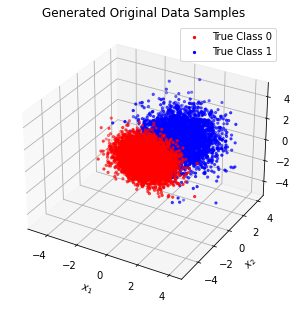

Num samples: 0 = 6484, 1 = 3516


In [26]:
N = 10000 # Samples

# Means and Covariance Matrices
mu = np.array([[-1/2, -1/2, -1/2], [1, 1, 1]])
sigma = np.array([[[1,-0.5,0.3],[-0.5,1,-0.5],[0.3, -0.5, 1]],
                  [[1, 0.3, -0.2],[0.3, 1, 0.3],[-0.2, 0.3, 1]]])

priors = np.array([0.65, 0.35]) # Given Priors  

n = mu.shape[1] # Sample dimensions (3)
C = len(priors) # Number of Classes (2)
L = np.array(range(C)) # Define labels as [0 1]

# set thresholds: results in [0.0, 0.65, 1.0]
thresholds = np.cumsum(priors)
thresholds = np.insert(thresholds,0,0)

X = np.zeros([N,n]) # create empty matrix for samples of size 10,000 x 3
labels = np.zeros(N) # create empty labels array of length 10,000

# Create a 10000-length vector of uniformly distributed random variables in [0,1)
# Will be used to get an estimate of number of features belonging to each label
u = np.random.rand(N)

# Plot for original data and their true labels
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(131, projection = '3d')
marker_shapes = '..'
marker_colors = 'rb' 

for i in range(C):

    # Find indices of u that meet each prior
    indices = np.argwhere((thresholds[i] <= u) & (u <= thresholds[i+1]))[:, 0]

    Nl = len(indices) # Get number of indices in each component: should be ~ 6500 and 3500
    
    # set label vector based on above - will be vector of class labels [0 0 1 0 1 .. to 9999] in this case
    labels[indices] = i * np.ones(Nl)
    
    # for each valid index, insert 3D random sample using relevant gaussian distribution
    X[indices, :] = multivariate_normal.rvs(mu[i], sigma[i], Nl)

    # Add to scatter plot
    ax1.scatter(X[labels==i, 0], X[labels==i, 1], X[labels==i, 2], marker=marker_shapes[i], c=marker_colors[i], label="True Class {}".format(i))

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Generated Original Data Samples")
plt.tight_layout()
plt.show()

# Generate data distributions and store in true class labels
Nl = np.array([sum(labels == i) for i in range(C)])
print("Num samples: 0 = {}, 1 = {}".format(Nl[0],Nl[1]))


In [27]:
from sys import float_info # Threshold smallest positive floating value

# Generate ROC curve samples
def estimate_roc(discriminant_score, label):
    Nlabels = np.array((sum(label == 0), sum(label == 1))) #~[6500,3500]

    sorted_score = sorted(discriminant_score)

    # Use tau values that will account for every possible classification split
    # These are all the possible values of Gamma that we will test through
    taus = ([sorted_score[0] - float_info.epsilon] + sorted_score +
             [sorted_score[-1] + float_info.epsilon])
        
    # Calculate the decision label for each observation for each gamma [10000]
    decisions = [discriminant_score >= t for t in taus]

    # True Positive
    ind11 = [np.argwhere((d==1) & (label==1)) for d in decisions]
    p11 = [len(inds)/Nlabels[1] for inds in ind11]
    # False Positive
    ind10 = [np.argwhere((d==1) & (label==0)) for d in decisions]
    p10 = [len(inds)/Nlabels[0] for inds in ind10]
    # True Negative
    ind01 = [np.argwhere((d==0) & (label==1)) for d in decisions]
    p01 = [len(inds)/Nlabels[1] for inds in ind01]
    # False Negative
    ind00 = [np.argwhere((d==0) & (label==0)) for d in decisions]
    p00 = [len(inds)/Nlabels[0] for inds in ind00]
    
    # ROC has FPR on the x-axis and TPR on the y-axis
    roc = np.array((p10, p11))

    # Calculate error probability
    prob_error = [(p10[w] *priors[0] + (1 - p11[w])* priors[1]) for w in range(len(p10))]

    return roc, taus, prob_error

In [28]:
# Expected Risk Minimization Classifier - Estimated

# Class conditional likelihood is a 2x10,000 matrix of likelihoods for each sample based on gaussian distribution
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[l], sigma[l]) for l in L])

# Discriminant Score using log-likelihood ratio: is a 10,000-length vector of values to compare to the threshold
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Vary Gamma gradually and compute True-Positive and False-Positive probabilities
roc_erm, tau, prob_error = estimate_roc(discriminant_score_erm, labels)

# Find minimum error and index
minimum_error = min(prob_error)
minimum_index = prob_error.index(minimum_error)

# Experimental / approximate Threshold Gamma value
# e^ (undo log in prev cell)
gamma_approx = np.exp(tau[minimum_index])
print("Approximated Threshold: ", gamma_approx)
print("Approximated Minimum Error: ", minimum_error)

Approximated Threshold:  1.8453013865130947
Approximated Minimum Error:  0.05787151570787005


In [29]:
# Minimum Expected Risk Classification using Likelihood-Ratio Test
Lambda = np.ones((C, C)) - np.identity(C)
# Theoretical / Expected
# Gamma threshold for MAP decision rule (remove Lambdas and you obtain same gamma on priors only; 0-1 loss simplification)
gamma_th = (Lambda[1,0] - Lambda[0,0]) / (Lambda[0,1] - Lambda[1,1]) * priors[0]/priors[1]
# Same as: gamma_th = priors[0]/priors[1]
print("Theoretical Gamma / Threshold = ", gamma_th)

# get decision for EACH sample based on theoretically optimal threshold
decisions_map = discriminant_score_erm >= np.log(gamma_th)

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_map = np.argwhere((decisions_map==0) & (labels==0))
p_00_map = len(ind_00_map) / Nl[0]
# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / Nl[0]
# False Negative Probability
ind_01_map = np.argwhere((decisions_map==0) & (labels==1))
p_01_map = len(ind_01_map) / Nl[1]
# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / Nl[1]

# Theoretical 
roc_map = np.array((p_10_map, p_11_map))

# Probability of error for MAP classifier, empirically estimated
prob_error_th = (p_10_map *priors[0] + (1 - p_11_map)* priors[1])
print("Theoretical Minimum Error: ", prob_error_th)



Theoretical Gamma / Threshold =  1.8571428571428574
Theoretical Minimum Error:  0.05826969545758562


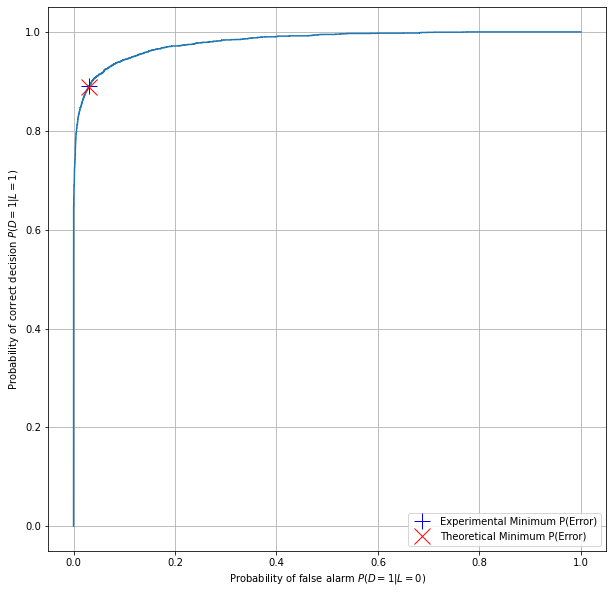

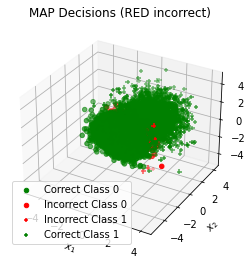

In [30]:
# Plot ROC
fig_roc, ax_roc = plt.subplots(figsize=(10, 10))
ax_roc.plot(roc_erm[0], roc_erm[1])
ax_roc.plot(roc_erm[0,minimum_index], roc_erm[1,minimum_index],'b+', label="Experimental Minimum P(Error)", markersize=16)
ax_roc.plot(roc_map[0], roc_map[1], 'rx', label="Theoretical Minimum P(Error)", markersize=16)
ax_roc.legend()
ax_roc.set_xlabel(r"Probability of false alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of correct decision $P(D=1|L=1)$")
plt.grid(True)

fig_roc;


# Display MAP decisions
fig = plt.figure(figsize=(10, 10))
ax4 = fig.add_subplot(131, projection = '3d')

# class 0 circle, class 1 +, correct green, incorrect red
ax4.scatter(X[ind_00_map, 0], X[ind_00_map, 1], X[ind_00_map, 2], c='g',marker='o', label="Correct Class 0")
ax4.scatter(X[ind_10_map, 0], X[ind_10_map, 1], X[ind_10_map, 2], c='r',marker='o', label="Incorrect Class 0")
ax4.scatter(X[ind_01_map, 0], X[ind_01_map, 1], X[ind_01_map, 2], c='r',marker='+', label="Incorrect Class 1")
ax4.scatter(X[ind_11_map, 0], X[ind_11_map, 1], X[ind_11_map, 2], c='g',marker='+', label="Correct Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("MAP Decisions (RED incorrect)")
plt.tight_layout()
plt.show()

In [31]:
# PART B
# ------------- EXPERIMENTAL --------------
# Naive Bayes Sigma value assumes incorrect covariance matrices setting off-diag vals to 0
sigma_b = np.array([[1, 0, 0],
                     [0, 1, 0],
                     [0, 0, 1]])

class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[l], sigma_b) for l in L])
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

roc_erm, tau, prob_error = estimate_roc(discriminant_score_erm, labels)

# Find minimum error and index
minimum_error = min(prob_error)
print("Minimum Error = ", minimum_error)
minimum_index = prob_error.index(minimum_error)

# Experimental / approximate Threshold Gamma value
# e^ (undo log in prev cell)
gamma_approx = np.exp(tau[minimum_index])
print("Approximated Threshold = ", gamma_approx)

# ------------- THEORETICAL --------------
# get decision for EACH sample, same gamma_th (analytical soln)
decisions_map = discriminant_score_erm >= np.log(gamma_th)

# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / Nl[0]

# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / Nl[1]

roc_map = np.array((p_10_map, p_11_map))

Minimum Error =  0.06777278488608346
Approximated Threshold =  0.9637043513224697


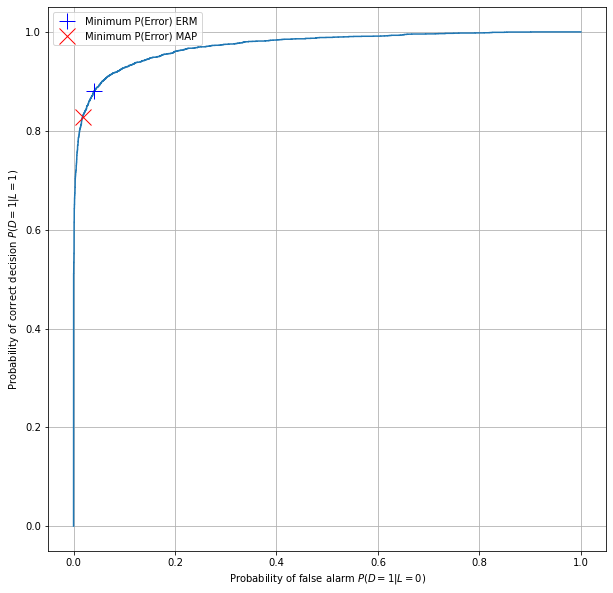

In [32]:
fig_roc, ax_roc = plt.subplots(figsize=(10, 10))
ax_roc.plot(roc_erm[0], roc_erm[1])
ax_roc.plot(roc_erm[0,minimum_index], roc_erm[1,minimum_index],'b+', label="Minimum P(Error) ERM", markersize=16)
ax_roc.plot(roc_map[0], roc_map[1], 'rx', label="Minimum P(Error) MAP", markersize=16)
ax_roc.legend()
ax_roc.set_xlabel(r"Probability of false alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of correct decision $P(D=1|L=1)$")
plt.grid(True)

fig_roc;

In [33]:
# PART C
def perform_lda(X, mu, Sigma, C=2):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).

    In practice the mean and covariance parameters would be estimated from training samples.
    
    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        mu: Mean vector [C, n].
        Sigma: Covariance matrices [C, n, n].

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """
    
    mu = np.array([mu[i].reshape(-1, 1) for i in range(C)])
    cov = np.array([Sigma[i].T for i in range(C)])

    # Determine between class and within class scatter matrix
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]

    # Extract corresponding sorted eigenvectors
    U = U[:, idx]

    # First eigenvector is now associated with the maximum eigenvalue, mean it is our LDA solution weight vector
    w = U[:, 0]

    # Scalar LDA projections in matrix form
    z = X.dot(w)

    return w, z

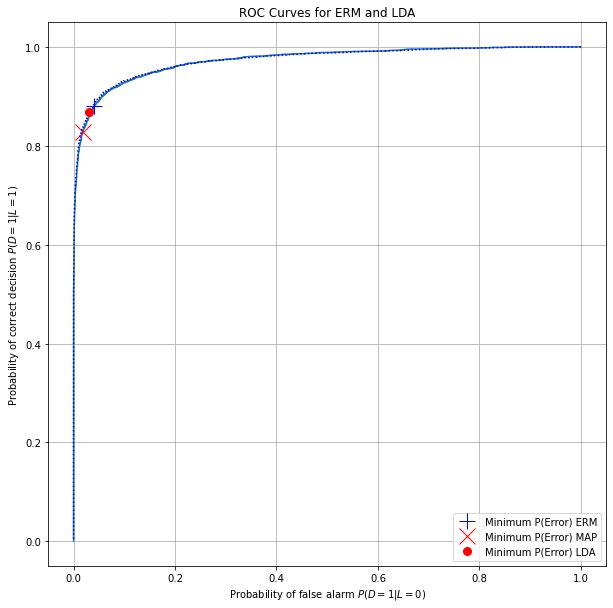

In [34]:
# Fisher LDA Classifer (using true model parameters)
_, discriminant_score_lda = perform_lda(X, mu, sigma)

# Estimate the ROC curve for this LDA classifier
roc_lda, tau_lda, min_error_lda = estimate_roc(discriminant_score_lda, labels)

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
prob_error_lda = np.array((roc_lda[0,:], 1 - roc_lda[1,:])).T.dot(Nl.T / N)

# Min prob error
min_prob_error_lda = np.min(prob_error_lda)
min_ind = np.argmin(prob_error_lda)

# Display the estimated ROC curve for LDA and indicate the operating points
# with smallest empirical error probability estimates (could be multiple)
ax_roc.plot(roc_lda[0], roc_lda[1], 'b:')
ax_roc.plot(roc_lda[0, min_ind], roc_lda[1, min_ind], 'r.', label="Minimum P(Error) LDA", markersize=16)
ax_roc.set_title("ROC Curves for ERM and LDA")
ax_roc.legend()

fig_roc

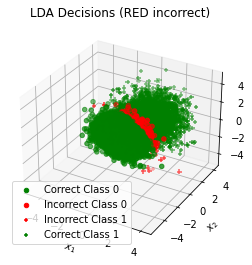

Smallest P(error) for ERM = 0.05826969545758562
Smallest P(error) for LDA = 0.06610000000000002


In [35]:
# Use min-error threshold
decisions_lda = discriminant_score_lda >= tau_lda[min_ind]

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_lda = np.argwhere((decisions_lda==0) & (labels==0))
p_00_lda = len(ind_00_lda) / Nl[0]
# False Positive Probability
ind_10_lda = np.argwhere((decisions_lda==1) & (labels==0))
p_10_lda = len(ind_10_lda) / Nl[0]
# False Negative Probability
ind_01_lda = np.argwhere((decisions_lda==0) & (labels==1))
p_01_lda = len(ind_01_lda) / Nl[1]
# True Positive Probability
ind_11_lda = np.argwhere((decisions_lda==1) & (labels==1))
p_11_lda = len(ind_11_lda) / Nl[1]

# Display LDA decisions
fig = plt.figure(figsize=(10, 10))
ax_c = fig.add_subplot(131, projection = '3d')

# class 0 circle, class 1 +, correct green, incorrect red
ax_c.scatter(X[ind_00_lda, 0], X[ind_00_lda, 1], X[ind_00_lda, 2], c='g',marker='o', label="Correct Class 0")
ax_c.scatter(X[ind_10_lda, 0], X[ind_10_lda, 1], X[ind_10_lda, 2], c='r',marker='o', label="Incorrect Class 0")
ax_c.scatter(X[ind_01_lda, 0], X[ind_01_lda, 1], X[ind_01_lda, 2], c='r',marker='+', label="Incorrect Class 1")
ax_c.scatter(X[ind_11_lda, 0], X[ind_11_lda, 1], X[ind_11_lda, 2], c='g',marker='+', label="Correct Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("LDA Decisions (RED incorrect)")
plt.tight_layout()
plt.show()

print("Smallest P(error) for ERM = {}".format(prob_error_th))
print("Smallest P(error) for LDA = {}".format(min_prob_error_lda))